In [1]:
%load_ext autoreload

In [2]:
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw
from pathlib import Path

In [3]:
# diretório do MASKR
ROOT_DIR = '/home/henriqueleal/Documentos/mask_healthy'
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist. Did you forget to read the instructions above? ;)'

# Importação de bibliotecas
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib

/home/henriqueleal/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/henriqueleal/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/henriqueleal/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/henriqueleal/.local/lib/python3.6/site-packages/tensorflow/python/f

# Carregamento do modelo pré-treinado


In [4]:
# diretório para salvamento
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# diretório do modelo pré-treinado
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# download do modelo
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Configuração do Coco Dataset


In [5]:
class CocoSynthConfig(Config):

 
    NAME = "cocosynth_dataset"

   
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    
    NUM_CLASSES = 1 + 1  # background + classes

   
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # iterações por epocas
    STEPS_PER_EPOCH = 1000

   
    VALIDATION_STEPS = 5
    
    
    BACKBONE = 'resnet50'

    
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    
config = CocoSynthConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

# Leitura do JSON do COCO Dataset


In [6]:
class CocoLikeDataset(utils.Dataset):
    
    def load_data(self, annotation_json, images_dir):
      
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
       
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

# Carregamento do dataset de treinamento e validação

In [7]:
dataset_train = CocoLikeDataset()
dataset_train.load_data('../datasets/box_dataset_synthetic/train/coco_instances.json',
                        '../datasets/box_dataset_synthetic/train/images')
dataset_train.prepare()

dataset_val = CocoLikeDataset()
dataset_val.load_data('../datasets/box_dataset_synthetic/val/coco_instances.json',
                      '../datasets/box_dataset_synthetic/val/images')
dataset_val.prepare()

## Verificação dos dados


Displaying examples from training dataset:


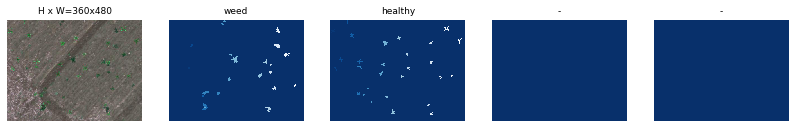

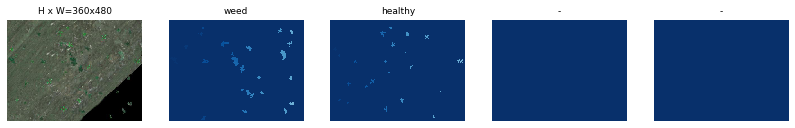

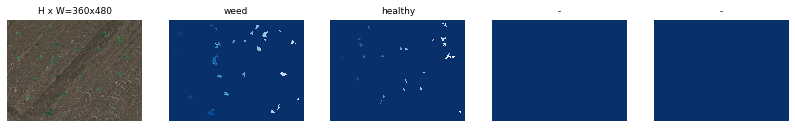

Displaying examples from validation dataset:


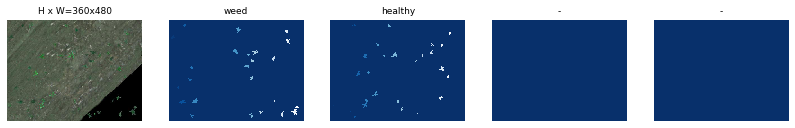

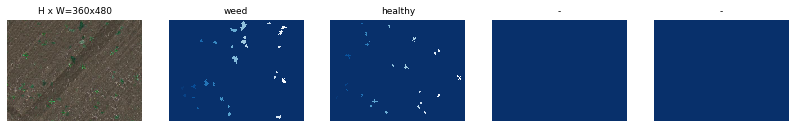

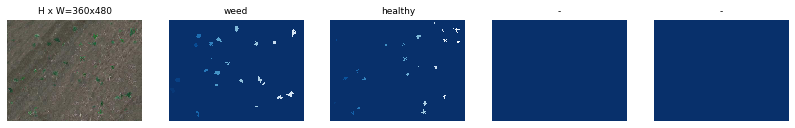

In [8]:
for name, dataset in [('training', dataset_train), ('validation', dataset_val)]:
    print(f'Displaying examples from {name} dataset:')
    
    image_ids = np.random.choice(dataset.image_ids, 3)
    for image_id in image_ids:
        image = dataset.load_image(image_id)
        mask, class_ids = dataset.load_mask(image_id)
        visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

## Criação do Modelo em modo de treinamento


In [9]:

model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [15]:

init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":

    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    model.load_weights("/home/henriqueleal/Documentos/mask_healthy/logs/cocosynth_dataset20200815T0220/mask_rcnn_cocosynth_dataset_0005.h5", by_name=True)

Re-starting from epoch 5


## Treinamento


In [11]:
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=5, 
            layers='heads')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/henriqueleal/Documentos/Mask_RCNN/logs/weed_dataset20200815T1656/mask_rcnn_weed_dataset_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4     

/home/henriqueleal/.local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/henriqueleal/.local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/henriqueleal/.local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor




/home/henriqueleal/.local/lib/python3.6/site-packages/keras/engine/training.py:2039: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/5
 999/1000 [============================>.] - ETA: 4s - loss: 1.8953 - rpn_class_loss: 0.1216 - rpn_bbox_loss: 0.5697 - mrcnn_class_loss: 0.3662 - mrcnn_bbox_loss: 0.4033 - mrcnn_mask_loss: 0.4344

/home/henriqueleal/.local/lib/python3.6/site-packages/keras/engine/training.py:2197: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


1000/1000 [==============================] - 4066s 4s/step - loss: 1.8948 - rpn_class_loss: 0.1216 - rpn_bbox_loss: 0.5696 - mrcnn_class_loss: 0.3662 - mrcnn_bbox_loss: 0.4031 - mrcnn_mask_loss: 0.4344 - val_loss: 1.5810 - val_rpn_class_loss: 0.0641 - val_rpn_bbox_loss: 0.4314 - val_mrcnn_class_loss: 0.3462 - val_mrcnn_bbox_loss: 0.3460 - val_mrcnn_mask_loss: 0.3933
Epoch 2/5
1000/1000 [==============================] - 3986s 4s/step - loss: 1.5822 - rpn_class_loss: 0.0564 - rpn_bbox_loss: 0.4065 - mrcnn_class_loss: 0.3726 - mrcnn_bbox_loss: 0.3371 - mrcnn_mask_loss: 0.4096 - val_loss: 1.4470 - val_rpn_class_loss: 0.0558 - val_rpn_bbox_loss: 0.3473 - val_mrcnn_class_loss: 0.2969 - val_mrcnn_bbox_loss: 0.3352 - val_mrcnn_mask_loss: 0.4117
Epoch 3/5
1000/1000 [==============================] - 3980s 4s/step - loss: 1.4847 - rpn_class_loss: 0.0460 - rpn_bbox_loss: 0.3668 - mrcnn_class_loss: 0.3620 - mrcnn_bbox_loss: 0.3178 - mrcnn_mask_loss: 0.3921 - val_loss: 1.5157 - val_rpn_class_loss:

In [ ]:
# Fine tune all layers
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=10, 
            layers="all")
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 5. LR=0.0001

Checkpoint Path: /home/henriqueleal/Documentos/Mask_RCNN/logs/cocosynth_dataset20200815T0220/mask_rcnn_cocosynth_dataset_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
r

/home/henriqueleal/.local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/henriqueleal/.local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/henriqueleal/.local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor




/home/henriqueleal/.local/lib/python3.6/site-packages/keras/engine/training.py:2039: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 6/10
 999/1000 [============================>.] - ETA: 5s - loss: 1.3758 - rpn_class_loss: 0.0356 - rpn_bbox_loss: 0.3217 - mrcnn_class_loss: 0.3792 - mrcnn_bbox_loss: 0.2637 - mrcnn_mask_loss: 0.3755 

/home/henriqueleal/.local/lib/python3.6/site-packages/keras/engine/training.py:2197: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


# Preparação da Inferência


In [16]:
class InferenceConfig(CocoSynthConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    DETECTION_MIN_CONFIDENCE = 0.01
    

inference_config = InferenceConfig()

In [17]:
# Criação do modelo em modo de inferência
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

### Load dos pesos

In [20]:
model_path = "/home/henriqueleal/Documentos/mask_healthy/logs/cocosynth_dataset20200815T0220/mask_rcnn_cocosynth_dataset_0005.h5"



assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights("/home/henriqueleal/Documentos/mask_healthy/logs/cocosynth_dataset20200815T0220/mask_rcnn_cocosynth_dataset_0005.h5", by_name=True)

Loading weights from  /home/henriqueleal/Documentos/mask_healthy/logs/cocosynth_dataset20200815T0220/mask_rcnn_cocosynth_dataset_0005.h5
Re-starting from epoch 5


# Resultados

Processing 1 images
image                    shape: (360, 480, 3)         min:   24.00000  max:  214.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   92.20000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


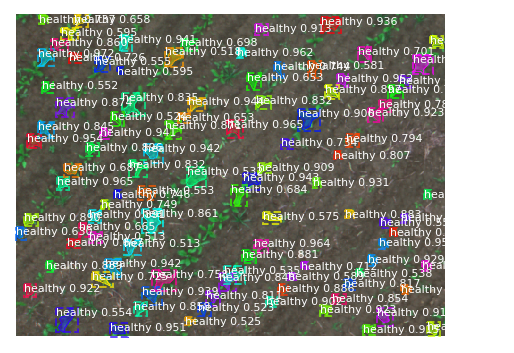

38 24 57 42
117 236 137 254
181 46 195 59
251 266 266 282
37 247 48 258
250 406 262 417
133 12 149 28
66 359 80 372
345 105 360 125
92 192 107 212
177 254 195 273
273 100 293 118
144 143 165 165
22 116 40 130
126 94 138 105
304 141 324 163
2 342 20 364
182 332 193 342
268 394 281 404
324 340 337 353
104 394 119 411
301 9 315 22
328 404 348 422
347 388 358 402
10 268 22 282
165 271 177 286
105 316 129 340
302 431 312 442
315 280 326 292
78 346 94 362
143 78 157 93
218 82 233 95
222 9 236 24
275 34 287 43
301 293 313 304
218 368 227 379
263 253 277 269
44 444 66 467
93 45 114 65
118 167 138 185
217 141 244 165
26 39 39 58
321 132 337 147
312 354 323 369
289 227 309 246
119 24 137 42
87 119 113 144
162 126 181 147
90 269 105 286
222 431 233 441
295 367 307 380
309 213 325 228
152 356 161 365
196 457 206 465
133 369 147 384
275 455 286 465
78 417 93 433
95 406 108 420
285 152 309 179
207 95 217 104
196 110 205 117
52 289 70 300
23 464 37 478
0 26 10 36
138 297 150 310
42 59 53 73
287 85 30

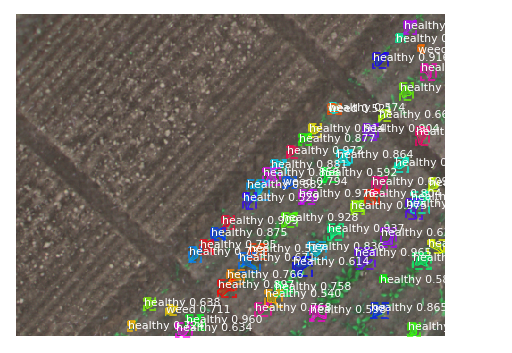

195 317 211 336
208 375 222 390
146 303 160 315
54 453 72 470
261 380 284 402
336 190 352 210
234 349 252 366
221 298 237 315
182 462 197 473
6 434 21 448
42 400 59 417
122 328 136 342
225 231 239 244
122 389 140 405
296 226 315 246
125 448 145 463
266 445 284 465
162 286 176 302
133 317 145 330
238 218 252 234
322 398 339 416
151 359 168 376
171 276 190 295
254 327 273 347
344 439 359 452
160 424 175 439
195 391 211 407
252 206 267 221
198 442 221 463
322 268 337 285
285 236 301 255
299 290 314 309
251 461 266 479
259 194 276 207
342 125 353 134
184 259 207 283
21 425 30 436
266 250 287 273
106 407 118 419
76 430 95 445
317 143 330 156
238 409 259 426
345 179 360 197
206 437 228 455
271 310 292 331
181 399 200 415
325 329 342 347
171 341 187 360
291 408 299 417
98 350 109 362
307 279 326 298
199 254 217 269
256 261 273 280
Saudáveis:  53
Daninhas:  4
Total detectadas:  57
Processing 1 images
image                    shape: (360, 480, 3)         min:   32.00000  max:  214.00000  uint8


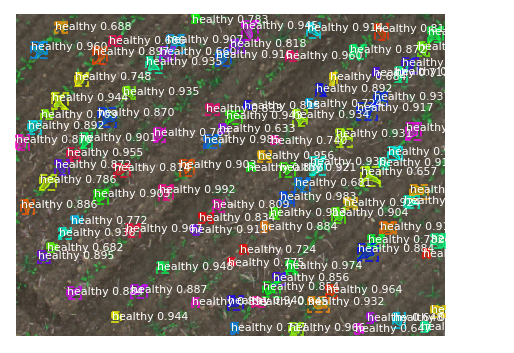

190 160 207 176
134 210 149 228
198 295 213 311
333 422 350 436
147 416 162 432
275 302 290 315
234 123 248 139
345 306 358 321
302 347 316 359
40 302 51 315
30 17 48 35
13 461 30 478
30 450 45 463
152 271 164 286
149 57 163 72
276 158 288 170
6 253 27 271
315 264 327 278
87 40 105 58
332 107 343 117
107 235 122 253
314 237 330 254
86 401 100 415
238 48 250 61
80 120 94 133
47 146 64 163
106 310 124 326
315 327 332 350
127 358 147 376
159 329 179 346
205 367 217 382
165 296 181 312
202 434 216 451
231 408 245 426
98 382 117 404
39 224 57 241
9 326 25 340
216 284 228 296
235 196 246 207
160 406 172 418
22 169 42 188
216 354 233 368
195 87 211 103
162 184 180 199
132 72 149 85
35 86 54 102
343 453 355 464
264 25 277 38
77 336 90 347
118 13 133 28
316 197 326 205
48 432 65 450
302 129 316 147
207 6 222 20
231 274 242 284
256 383 275 405
304 57 318 73
162 44 179 59
33 374 49 392
134 0 151 14
104 92 125 112
245 465 261 480
289 288 302 301
299 277 315 295
190 441 206 461
121 437 139 453
165 

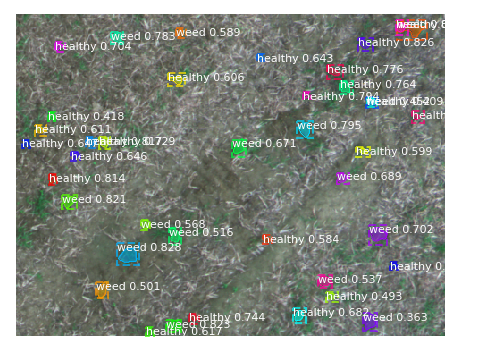

276 419 285 428
25 383 40 400
136 78 148 90
178 37 190 46
86 321 94 330
56 348 71 366
73 363 88 377
334 194 346 205
136 93 150 105
30 43 41 55
328 310 345 325
107 443 120 457
139 7 148 16
153 62 163 71
43 270 51 278
349 146 359 154
123 21 135 34
65 170 79 189
147 381 159 396
246 276 256 287
310 347 321 360
5 425 22 439
108 36 118 44
92 393 103 404
Saudáveis:  24
Daninhas:  16
Total detectadas:  40
Processing 1 images
image                    shape: (360, 480, 3)         min:   43.00000  max:  236.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  112.20000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


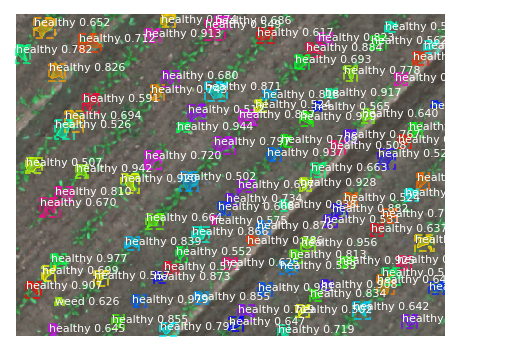

335 432 350 449
300 271 314 287
108 318 124 333
313 130 327 145
267 39 283 56
249 319 264 335
120 180 131 195
167 67 182 81
207 295 219 306
149 281 163 297
182 318 197 330
270 362 283 379
178 117 199 138
82 346 93 359
246 447 264 468
15 144 30 161
296 341 307 354
298 11 316 28
31 325 46 343
211 354 227 371
230 270 245 284
287 154 300 167
299 463 312 479
75 212 96 236
237 197 254 216
194 436 208 450
106 250 123 270
336 107 351 121
310 199 323 215
269 427 285 442
248 122 263 138
120 440 136 455
307 329 320 342
54 37 73 55
20 338 33 354
84 276 95 291
263 307 277 320
192 44 209 64
136 222 155 245
344 161 359 181
247 259 257 270
33 0 53 15
134 428 148 442
217 410 233 427
57 367 73 382
41 445 56 461
128 367 143 381
78 151 95 166
200 235 212 248
152 144 172 162
324 248 342 266
347 293 358 306
21 70 41 95
134 297 147 308
65 424 78 438
281 29 297 44
184 248 198 267
107 55 130 75
44 312 60 328
96 465 103 476
1 223 15 239
62 163 80 182
205 27 226 49
209 226 224 240
222 145 239 164
165 330 181 346

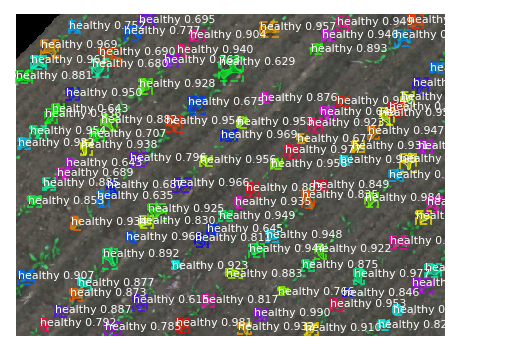

328 266 342 281
199 391 215 405
339 179 356 194
145 301 161 317
284 378 301 390
28 28 48 47
128 230 141 247
182 176 198 195
324 422 336 433
243 123 254 135
45 17 60 33
157 363 168 375
161 286 172 298
7 273 24 293
157 206 169 219
124 16 137 34
113 168 131 186
114 247 126 259
318 351 330 365
104 408 123 423
81 56 95 70
2 359 16 373
219 227 230 242
241 280 254 293
124 394 138 407
17 343 29 356
256 261 270 278
16 424 34 441
33 180 46 193
90 359 101 373
140 73 156 85
203 245 216 255
226 61 240 72
137 2 150 15
344 249 357 263
141 376 153 390
71 138 88 152
0 439 14 456
247 419 262 439
211 148 230 168
115 327 131 343
275 175 284 185
256 335 273 347
203 460 220 477
173 418 185 433
345 323 358 338
70 445 89 461
286 2 301 20
16 195 29 211
53 464 65 478
141 450 154 466
32 330 43 343
262 97 284 113
325 43 338 56
294 443 311 466
182 30 196 44
188 257 202 272
284 235 294 253
112 95 129 113
62 0 76 18
294 69 307 84
87 274 98 286
274 320 286 334
306 60 320 74
202 13 214 28
184 333 197 347
306 366 314 3

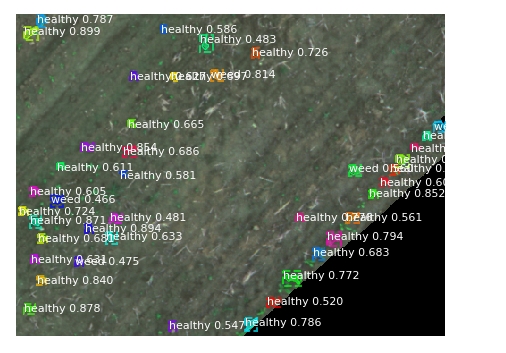

13 9 27 25
234 77 244 86
323 9 334 21
225 16 238 28
143 73 152 87
195 395 204 405
292 23 302 34
167 419 179 429
156 426 170 440
243 348 258 364
0 23 13 34
339 256 353 270
222 314 230 322
286 299 303 319
37 264 48 272
130 456 140 465
215 3 224 13
144 442 150 452
64 173 73 180
147 120 158 134
261 332 274 345
245 25 255 35
117 125 125 133
243 101 256 113
268 17 277 26
63 128 72 136
165 46 172 55
182 408 191 418
192 16 202 26
11 162 20 168
174 116 180 124
221 370 232 384
342 171 353 179
316 281 327 295
22 206 41 220
222 105 233 119
Saudáveis:  36
Daninhas:  5
Total detectadas:  41
Processing 1 images
image                    shape: (360, 480, 3)         min:   43.00000  max:  236.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  109.20000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


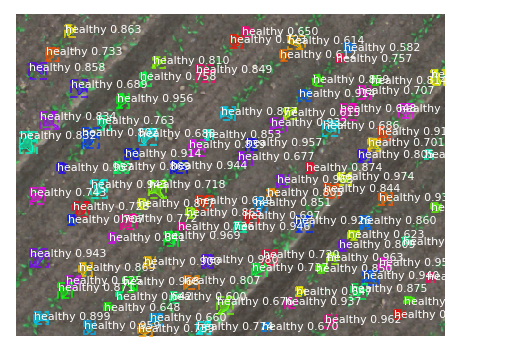

268 208 283 221
176 360 190 375
242 166 258 181
293 120 310 135
179 292 192 304
266 348 278 360
336 346 350 359
342 76 357 88
272 407 284 419
138 258 151 270
165 46 176 57
88 113 104 126
231 244 243 258
163 174 176 191
184 84 204 102
262 15 282 36
286 388 302 405
316 301 328 313
199 407 212 421
115 285 131 302
225 312 242 331
125 405 140 419
150 122 161 137
83 317 96 330
210 465 220 476
271 143 283 155
99 429 115 445
332 20 346 36
103 229 117 245
206 137 217 148
301 375 318 393
165 325 177 335
300 47 317 63
164 110 177 125
277 70 292 85
216 190 227 201
11 55 24 66
225 385 239 397
67 332 79 344
53 14 71 34
128 212 139 221
205 268 220 281
279 336 289 348
56 201 75 223
189 345 205 360
244 104 255 114
140 194 157 211
108 27 127 47
130 4 154 23
68 397 78 409
46 153 59 167
252 362 264 372
292 188 306 205
151 383 164 397
194 281 202 292
126 74 148 93
330 423 340 435
343 203 357 217
223 118 239 134
113 92 128 105
64 139 79 151
43 358 52 368
193 15 211 32
151 458 161 467
346 137 359 152
278 264

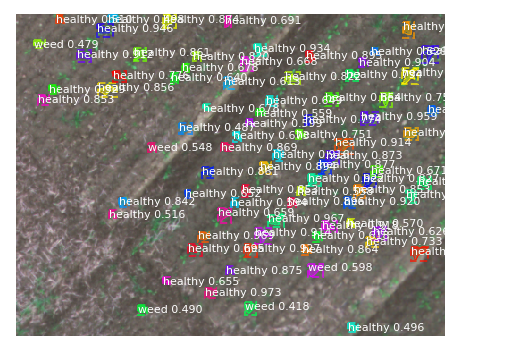

305 212 317 224
242 204 254 216
223 282 237 300
108 386 123 405
126 435 139 450
10 91 24 108
181 450 194 465
32 266 45 280
78 37 88 48
256 255 270 270
178 327 191 341
203 367 216 380
230 343 243 359
151 288 163 299
138 357 155 377
238 268 256 285
39 68 52 84
48 384 58 394
204 304 215 314
40 325 52 334
164 273 178 286
162 339 178 353
281 235 290 244
0 165 14 179
152 347 166 362
143 230 152 243
257 320 268 330
170 208 182 221
37 132 51 146
76 92 91 113
87 346 101 361
89 25 100 37
190 378 204 391
190 253 203 262
101 461 113 473
204 115 215 126
34 455 53 473
178 388 192 403
63 301 77 318
41 198 51 207
61 369 73 383
62 108 74 123
112 323 123 332
87 408 102 421
259 442 275 461
128 314 138 323
248 392 259 405
256 192 269 208
1 234 13 241
54 186 63 194
99 209 106 217
130 243 142 252
169 398 181 410
47 252 62 265
216 226 232 241
293 164 301 172
195 189 205 195
90 280 101 292
65 173 77 181
7 433 25 446
59 432 77 450
237 400 251 414
242 332 254 343
69 233 82 244
116 257 124 266
205 241 215 248
22

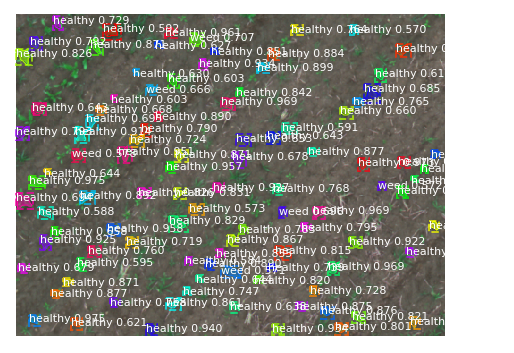

335 14 348 27
180 14 194 32
160 383 174 395
276 349 291 362
92 230 106 245
214 332 228 346
14 167 25 180
234 102 247 116
164 168 176 179
147 114 165 130
346 146 358 158
49 205 61 216
346 287 358 300
191 427 205 439
188 220 198 233
246 27 263 39
248 373 261 387
125 66 143 82
338 441 351 452
53 270 64 283
197 71 211 88
273 212 285 223
108 155 118 163
38 282 50 294
307 39 316 51
148 327 157 339
326 342 340 356
321 314 331 326
151 178 164 192
28 83 44 97
294 52 303 64
246 236 258 248
317 168 330 185
262 224 271 234
167 453 176 461
133 246 146 263
36 218 43 227
151 465 160 475
81 246 90 255
193 177 206 190
225 171 242 192
38 0 56 18
193 137 205 151
32 426 47 442
332 376 345 391
292 266 300 276
258 290 274 308
260 437 270 448
344 357 358 372
233 319 241 330
125 0 140 14
24 15 39 29
122 140 136 151
230 463 242 474
235 250 245 260
189 288 201 299
92 377 103 389
11 308 22 321
258 80 271 95
317 105 327 116
304 187 313 196
278 282 286 291
1 41 16 52
303 329 314 339
134 127 147 143
248 123 260 137

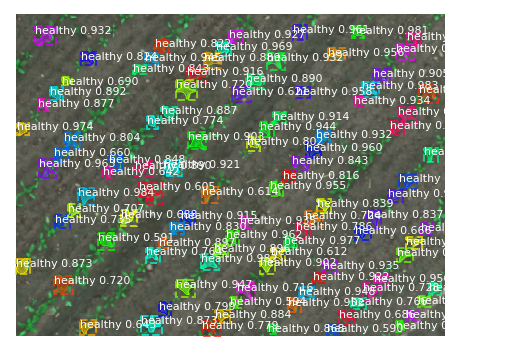

193 69 212 87
74 387 91 406
267 207 285 227
12 376 25 390
247 300 263 315
120 1 134 14
30 224 45 241
78 451 98 472
161 26 182 45
241 235 257 250
11 310 28 326
314 450 327 464
143 325 160 342
80 313 92 329
195 417 209 433
148 457 164 473
37 349 50 368
186 284 202 299
317 305 332 319
290 401 303 417
330 437 342 450
304 317 318 334
296 179 315 200
42 144 55 159
119 273 136 289
233 454 246 466
225 251 238 262
275 344 287 358
90 378 102 390
42 281 61 301
12 21 33 45
129 336 143 352
16 238 30 254
288 332 300 346
162 166 180 186
58 191 76 214
219 185 235 200
108 288 121 302
60 400 77 419
131 193 150 213
272 273 290 290
249 160 260 172
256 222 271 237
80 38 95 53
66 258 81 278
163 133 180 152
42 210 59 230
102 162 117 180
330 223 345 240
118 419 134 435
94 25 107 37
342 426 354 435
337 140 358 163
273 0 290 15
346 282 357 293
156 104 174 120
178 429 194 449
261 427 276 445
158 309 174 328
55 131 66 145
206 337 221 353
103 428 123 449
218 393 238 409
232 172 245 188
41 73 55 89
27 155 42 171
17

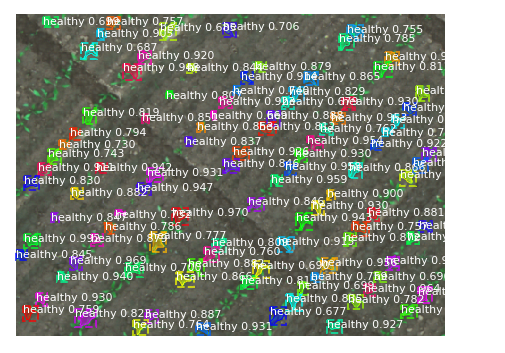

245 9 260 27
79 448 96 462
270 414 285 429
216 175 235 193
270 60 285 74
230 451 243 466
301 390 314 402
179 286 191 298
164 301 179 314
272 341 288 359
135 326 151 344
109 353 122 368
54 120 72 140
188 135 201 151
221 313 240 331
165 89 176 102
287 46 299 58
243 438 256 451
171 147 187 164
344 201 358 217
92 365 106 380
208 331 223 345
311 22 325 35
150 312 164 326
341 348 356 365
304 450 322 466
147 243 162 261
41 413 56 429
91 227 104 242
139 397 151 410
40 136 54 151
248 293 265 311
63 252 77 265
165 24 179 39
15 91 28 101
195 348 207 357
173 430 191 448
149 455 163 470
107 281 124 295
330 144 344 159
193 61 206 75
273 193 292 210
216 394 230 407
52 268 63 280
245 84 258 97
112 421 126 434
244 367 258 381
98 433 112 448
287 179 304 199
165 373 182 387
63 322 78 338
120 203 130 211
110 141 121 149
221 39 231 48
204 260 219 278
161 232 177 250
263 0 274 12
54 191 64 201
136 189 146 200
312 302 331 320
180 9 195 26
80 306 96 322
329 66 349 89
104 75 122 90
292 252 306 270
119 272 134 

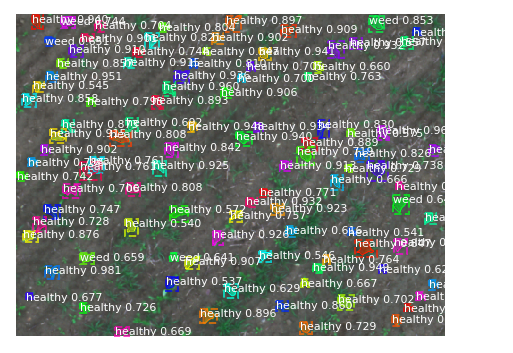

281 32 295 48
124 405 140 418
75 165 90 178
63 34 74 46
278 332 289 345
119 193 131 203
36 272 50 285
131 246 146 264
0 18 15 30
62 177 76 194
120 266 131 276
204 257 215 270
29 349 48 367
221 458 234 470
336 421 348 431
241 220 257 232
163 153 180 168
211 286 224 300
127 38 143 56
48 121 59 133
163 295 174 308
33 59 47 75
11 297 24 313
271 189 284 205
81 230 92 242
145 28 156 38
20 219 32 232
21 73 29 87
1 235 18 252
329 206 345 225
90 152 105 165
137 320 153 337
24 431 38 444
241 8 254 24
117 51 131 65
320 291 331 304
88 7 102 22
49 46 59 58
250 423 267 438
251 380 271 404
143 167 159 181
323 435 331 445
117 338 137 350
150 380 164 395
310 448 319 458
20 144 36 160
49 195 59 203
188 123 202 139
129 105 146 129
9 160 19 171
92 79 101 88
160 13 169 23
194 273 203 284
268 344 278 352
64 323 73 330
158 82 176 98
164 72 184 95
219 239 231 253
212 31 228 49
36 131 46 143
175 1 185 12
163 393 185 417
343 318 357 331
167 368 175 376
226 19 242 33
322 72 333 82
147 315 167 334
189 52 205 72
5

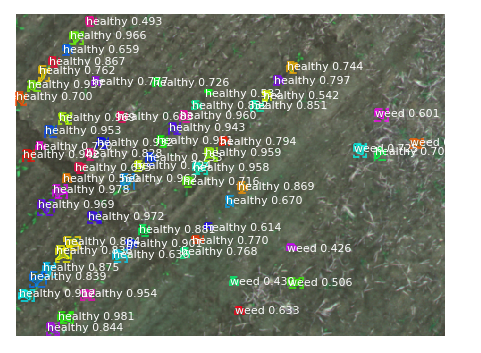

332 47 345 64
190 41 205 57
220 81 233 95
207 25 224 42
109 48 122 61
18 60 32 75
178 118 194 132
107 184 119 195
149 211 163 225
165 198 178 214
307 73 319 87
124 32 136 45
135 158 147 169
121 171 133 183
151 8 163 20
73 13 85 27
137 91 148 103
307 3 320 20
251 123 261 134
248 54 263 71
235 138 247 149
277 30 293 44
187 249 199 259
47 37 58 48
96 263 107 276
345 35 358 48
287 16 304 34
258 45 276 61
96 197 105 207
150 78 162 88
68 289 78 299
136 228 145 238
69 85 78 94
247 197 255 209
260 185 272 194
57 26 73 37
52 303 65 315
154 145 167 156
70 153 79 162
163 133 174 143
142 22 150 32
181 187 192 198
148 402 162 413
86 0 100 11
108 113 119 124
202 235 215 243
33 53 44 63
165 66 176 77
263 108 276 124
233 211 239 220
178 52 186 62
85 276 96 286
83 211 88 220
2 78 12 89
Saudáveis:  54
Daninhas:  7
Total detectadas:  61
Processing 1 images
image                    shape: (360, 480, 3)         min:   35.00000  max:  218.00000  uint8
molded_images            shape: (1, 512, 512, 3)      mi

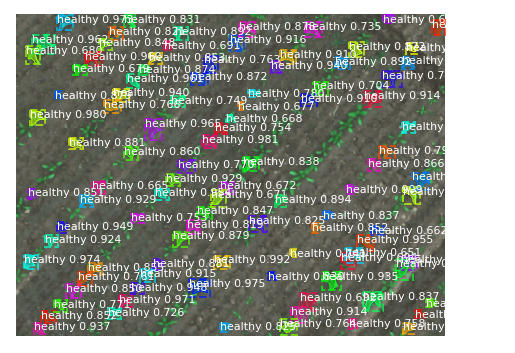

269 222 284 240
134 208 149 224
106 15 123 32
295 194 315 217
268 9 284 24
0 46 16 64
313 115 327 130
116 144 139 163
22 18 43 43
66 124 81 138
41 77 57 96
246 382 264 401
194 156 207 171
231 46 244 57
300 129 312 143
46 432 60 446
51 285 65 298
82 109 97 126
344 20 357 32
287 343 308 364
201 71 214 86
178 168 191 183
318 459 327 470
246 32 259 47
119 432 132 447
22 239 40 255
284 139 298 155
85 390 103 409
327 308 345 325
88 319 101 337
39 296 54 314
190 370 200 381
201 290 214 302
47 357 60 374
13 178 28 192
137 59 150 75
273 153 285 165
85 43 94 51
242 176 259 194
7 250 24 267
56 138 67 149
344 433 357 446
64 196 78 215
30 373 47 390
161 394 174 408
147 121 162 136
277 81 291 96
42 149 54 163
233 331 244 341
331 28 345 45
194 13 206 22
301 56 317 73
26 93 39 107
214 203 228 219
159 254 174 272
219 344 228 355
310 389 331 411
0 121 13 133
287 282 296 291
269 431 285 449
225 261 243 281
344 228 355 240
192 433 211 452
13 104 27 120
229 191 245 206
5 466 22 480
146 407 160 424
83 260 9

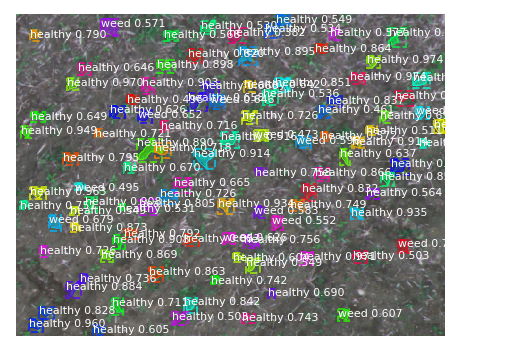

45 393 59 408
64 374 77 391
265 318 280 332
161 420 179 440
70 57 84 69
192 16 206 34
340 14 354 30
124 5 137 17
216 375 228 389
206 226 222 244
136 376 149 390
150 199 172 223
203 77 220 91
246 108 262 122
70 141 88 154
50 158 65 178
35 250 55 270
138 135 164 163
299 56 316 73
233 62 242 72
263 95 276 108
171 335 185 350
32 335 42 348
282 149 299 165
245 188 258 205
70 290 86 307
176 409 191 423
316 188 333 203
90 349 102 365
189 320 208 336
326 26 340 42
38 193 53 208
206 138 223 157
154 52 168 69
239 121 250 135
16 15 29 27
117 468 132 480
171 268 179 280
246 255 261 272
208 4 217 14
207 307 219 322
334 253 345 268
292 218 301 228
290 71 300 82
195 161 211 180
107 253 122 270
258 27 270 37
127 88 136 96
143 155 160 174
118 162 131 170
317 107 335 120
107 408 120 419
306 282 316 290
85 424 101 445
165 121 176 133
74 208 95 227
182 177 199 196
87 193 107 214
108 17 119 32
53 69 67 84
73 255 86 268
150 363 167 374
101 105 115 122
347 86 358 98
266 243 276 254
14 352 27 363
130 341 141 

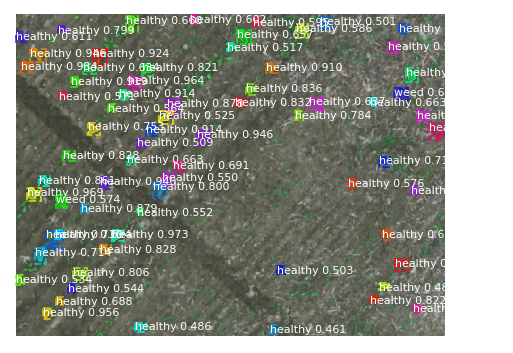

240 107 253 121
193 12 208 28
68 125 83 141
328 30 340 40
38 16 52 33
129 203 145 216
181 94 194 105
107 449 118 463
52 6 64 19
38 86 56 102
69 62 80 72
123 146 135 158
83 115 95 126
53 280 65 293
211 73 221 81
94 169 111 184
180 26 191 38
77 258 89 269
93 245 102 257
152 52 163 66
257 94 267 106
314 396 321 407
54 141 68 153
283 64 296 79
187 153 204 169
12 47 18 57
107 312 117 321
120 80 134 94
273 424 286 439
261 21 278 34
158 406 170 419
241 33 263 53
240 44 250 54
163 176 176 188
315 45 324 53
1 123 18 136
93 396 101 403
157 124 167 133
16 247 32 263
240 410 251 421
92 328 107 344
54 75 66 89
191 442 200 450
19 0 30 12
0 195 10 202
3 265 13 274
10 313 25 327
183 372 194 382
86 48 92 57
99 103 108 111
59 437 75 450
30 417 42 429
216 135 224 142
177 163 192 177
301 58 311 66
291 0 302 9
107 160 122 176
31 236 40 246
138 135 148 144
281 292 290 301
2 340 15 354
300 407 307 418
344 133 355 146
10 429 21 440
347 284 357 292
323 445 333 456
121 463 140 478
Saudáveis:  67
Daninhas:  2
To

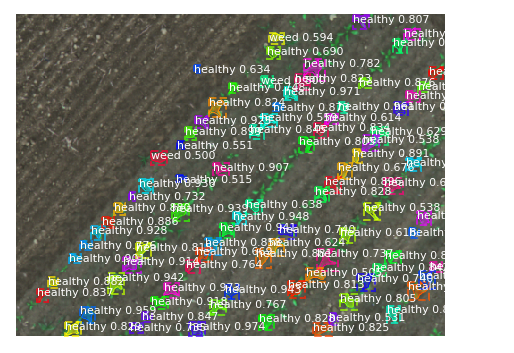

343 194 359 211
300 166 316 182
97 423 112 439
80 300 95 315
97 361 109 372
326 71 344 88
220 243 234 257
302 234 318 250
289 103 312 121
233 228 249 244
211 175 230 194
183 138 199 153
160 437 174 454
236 84 251 100
113 200 126 215
85 437 97 452
315 151 329 170
271 120 289 140
165 221 179 238
238 440 249 451
267 59 277 73
125 189 139 202
181 346 199 364
150 377 165 387
226 96 238 110
293 36 305 47
262 269 283 286
210 110 223 122
70 384 81 397
219 449 235 465
98 288 107 299
249 211 268 230
264 413 277 431
332 141 343 152
123 262 138 278
278 400 292 414
306 23 321 36
121 334 137 349
343 55 359 73
335 272 352 289
192 335 209 350
345 333 359 354
93 216 114 235
66 312 83 329
325 415 344 430
255 134 272 151
297 304 317 324
0 377 15 395
312 363 330 382
136 317 153 334
49 322 73 346
253 72 263 85
319 217 335 235
274 190 288 206
76 238 87 248
58 462 71 478
235 294 250 314
290 382 309 402
262 337 286 361
345 128 356 142
198 126 208 133
35 281 49 296
165 361 183 376
260 202 276 219
276 464 287 4

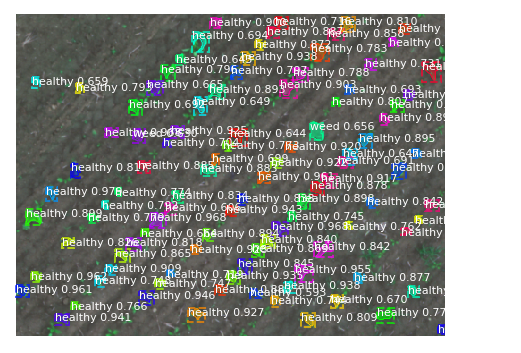

192 33 208 46
221 150 238 168
126 99 136 114
231 287 247 305
287 17 299 28
175 271 188 284
302 0 315 14
303 439 315 451
280 312 299 332
309 138 324 154
213 235 225 247
334 44 347 59
41 252 55 268
298 300 311 312
286 236 301 251
257 196 267 207
150 443 160 454
328 193 343 212
238 431 246 442
124 173 137 188
160 286 171 298
142 301 153 314
178 342 193 359
279 100 291 112
72 295 93 315
3 217 14 230
217 11 235 28
200 316 217 329
133 384 148 399
239 209 253 221
78 216 94 234
95 420 108 434
110 408 123 418
207 458 219 474
13 281 25 294
163 136 176 150
302 223 313 235
167 207 180 224
186 330 201 345
289 379 300 390
28 268 39 279
256 264 271 278
262 111 276 127
15 349 27 367
84 434 95 446
10 429 21 441
273 248 290 264
204 393 216 404
254 334 271 355
246 274 261 290
200 248 212 259
197 175 210 187
249 51 260 65
249 123 264 140
166 62 182 72
2 364 19 380
333 319 349 335
92 354 101 363
57 241 71 253
56 162 73 178
76 67 87 76
208 96 217 103
59 310 75 327
32 330 51 350
222 80 233 92
193 111 202 118

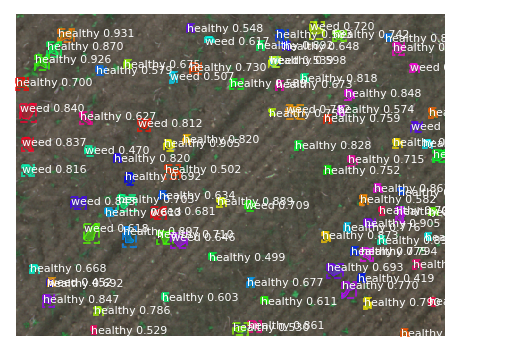

104 462 115 471
15 47 30 65
44 21 61 37
138 422 148 432
228 390 237 402
139 166 152 177
237 120 259 134
247 405 256 414
29 270 39 278
204 225 214 235
139 456 148 466
242 343 254 352
30 35 46 50
189 401 198 410
342 260 355 274
83 368 95 379
313 30 326 42
141 312 151 321
155 110 164 118
134 187 144 195
66 319 73 327
21 413 29 420
260 386 275 400
317 390 329 398
326 87 335 97
215 426 232 435
233 367 243 374
259 375 268 383
298 365 316 381
274 445 284 453
111 345 120 353
105 283 112 290
216 463 224 473
169 345 178 354
17 355 29 369
53 195 66 207
157 372 169 382
31 422 44 434
241 158 256 176
316 462 325 469
214 406 223 412
201 114 219 134
151 467 164 479
70 0 84 13
278 348 294 366
176 122 190 132
295 35 303 42
294 259 304 266
50 121 59 129
73 291 83 299
279 15 289 26
30 299 39 307
197 160 206 169
108 71 122 85
244 458 252 465
216 99 225 112
315 274 322 283
351 431 359 440
311 163 320 170
46 284 58 295
71 239 82 254
16 291 33 304
201 385 212 394
57 89 67 101
101 360 112 367
10 191 18 199
345

In [45]:
import skimage

real_test_dir = '../datasets/box_dataset_synthetic/test/images'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_train.class_names, r['scores'], figsize=(8,8))
    
    x_weeds = 0
    x_healthy = 0
    
    for i in range(0, len(r["scores"])):
        if r['class_ids'][i] == 2:
            (startY, startX, endY, endX) = r["rois"][i]
            x_healthy += 1
        else:
            x_weeds += 1
    
    print("Saudáveis: ", x_healthy)
    print("Daninhas: ", x_weeds)
    print("Total detectadas: ", x_weeds + x_healthy)